En este cuaderno se revisan las pruebas estadísticas que determinan si una combinación de pesos es mejor con respecto a otra

In [1]:
from tqdm.notebook import tqdm as tqm
import matplotlib.pyplot as plt
import plotly.graph_objs as go
from utils.func_aux import *
from utils.func_vis import *
import plotly.express as px
import scipy.stats as st
import seaborn as sns
import pandas as pd
import numpy as np

# Opciones de matplotlib
rc = plt.rcParams
rc["figure.figsize"] = [15, 5]

# Para mostrar todas las columnas cuando se imprime un df
pd.set_option("display.max_columns", None)

# Para poner el estilo de las gráficas de matplotlib parecido al de ggplot
plt.style.use("ggplot") 

# Definimos tablas que usaremos en el cuaderno
df_todos_PI=pd.read_csv('../tablas_generadas/todos_QI.csv')
w_sorted=np.sort(df_todos_PI['w_0'].unique())

df_QI=pd.read_csv('../tablas_generadas/QI_carac.csv')
dicc_indicadores={df_QI.indicador[i]:df_QI.Meta[i] for i in range(len(df_QI))}

go_to_Assesment()


# Kruskal-Wallis

Usamos la prueba de Kruskal Wallis para ver si hay diferencia significativa entre cada una de las diferentes combinaciones de parámetros. 

Aquellos donde se rechaza la hiṕótesis nula presentan una media diferente y por lo tanto si dependen de esta elección.

In [5]:
# def get_KW(df):
#     indicador_lista=[]
#     for wi in df.w_0.unique():
#         df_w0_unico =df.query(f'(w_0=={wi})').sort_values('run')
#         indicador_lista.append(df_w0_unico.valor_indicador.values)
#     try:
#         return st.kruskal(*indicador_lista)[1]
#     except:
#         return np.nan

# # Tarda 28 segundos
# df_KW_todos=df_todos_PI.dropna().groupby(['n_objetivos','problema','indicador','hiperparam_ind_conv']).apply(get_KW).reset_index().rename(columns={0:'p-value_KW'})
# df_KW_todos['Medias_Distintas']=df_KW_todos['p-value_KW'].apply(lambda x: 1 if x <= 0.05 else 0) # Para que se puedan sumar los False y True
# df_KW_todos

df_KW_todos=pd.read_csv('../tablas_generadas/KW_todos.csv')
df_KW_todos.sample(5)

,hiperparam_ind_conv,problema,n_objetivos,indicador,Medias_Distintas
1179,R2,DTLZ5,7,hv,0.0
489,R2,DTLZ3,4,spd,0.0
420,IGD+,WFG8,3,eps+,1.0
1171,R2,DTLZ4,7,r2,0.0
707,R2,DTLZ3,5,igd+,0.0


# Prueba de Friedman

La prueba de Kruskal se realiza con la suposición de que las muestras vienen de poblaciones no relacionadas. Dado que nuestros algoritmos distintos comparten puntos iniciales (las inicializaciones de las poblaciones dadas por las semillas) entonces tenemos que usar una prueba que compare a cada una de las corridas entre sí. 

Para esto, usamos la [prueba de Friedman](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.friedmanchisquare.html), obtenemos los $p$-valores y determinamos si se rechaza la hipótesis nula:

```H0: Todos los algoritmos tienen el mismo desempeño```

In [4]:
# def get_Friedman(df):
#     indicador_lista=[]
#     for wi in df.w_0.unique():
#         df_w0_unico =df.query(f'(w_0=={wi})').sort_values('run')
#         indicador_lista.append(df_w0_unico.valor_indicador.values)
#     try:
#         return st.friedmanchisquare(*indicador_lista)[1]
#     except:
#         return np.nan

# # Tarda 28 segundos
# df_Friedman_todos=df_todos_PI.dropna().groupby(['n_objetivos','problema','indicador','hiperparam_ind_conv']).apply(get_Friedman).reset_index().rename(columns={0:'p-value_Friedman'})
# df_Friedman_todos['Medias_Distintas']=df_Friedman_todos['p-value_Friedman'].apply(lambda x: 1 if x <= 0.05 else 0) # Para que se puedan sumar los False y True
df_Friedman_todos =pd.read_csv('../tablas_generadas/Friedman_todos.csv')
df_Friedman_todos.sample(5)

,n_objetivos,problema,indicador,hiperparam_ind_conv,p-value_Friedman,Medias_Distintas
1256,7,WFG3,s-energy,IGD+,0.347689,0
811,5,WFG3,spd,R2,0.665057,0
1043,6,WFG4,igd+,R2,0.144799,0
946,6,DTLZ4,r2,IGD+,0.690266,0
461,4,DTLZ1,spd,R2,0.667844,0


In [39]:
df_Friedman_todos['Medias_Distintas'].mean(), df_KW_todos['Medias_Distintas'].mean()

(0.2537202380952381, 0.22321428571428573)

Creamos tablas de la clasificación principal de cada indicador de calidad

In [9]:
QI_carac=pd.read_csv('../tablas_generadas/QI_carac.csv')
QI_carac

,indicador,Categoría,Meta
0,igd+,Convergencia,Minimize
1,r2,Convergencia,Maximize
2,s-energy,Diversidad,Maximize
3,eps+,Convergencia,Minimize
4,igd,Convergencia,Minimize
5,spd,Diversidad,Maximize
6,hv,Convergencia,Maximize


In [14]:
ind_conv_lista=['IGD+','R2']
for ind_conv in ind_conv_lista:
    df_KW_ind=df_Friedman_todos.query(f'hiperparam_ind_conv=="{ind_conv}"')
    
    
    df_KW_ind.n_objetivos=df_KW_ind.n_objetivos.astype(str)
    df_KW_ind=df_KW_ind.merge(right=QI_carac,how='inner',on='indicador')
    fig=px.bar(data_frame=df_KW_ind.groupby(['n_objetivos','indicador']).Medias_Distintas.mean().reset_index(),x='n_objetivos',y='Medias_Distintas',color='indicador', barmode='group')
    fig.update_layout(
        xaxis_title='Número de objetivos', yaxis_title='Diferencias promedio', yaxis=dict(range=[0,1]),
        height=500, width=900
    )
    fig.layout.yaxis.tickformat = ',.0%' 
    fig.update_xaxes(categoryorder='array',categoryarray=['2', '3','4', '5','6', '7', '10']) 
    fig.write_image(f'../imgs_pdf/Friedman_obj_indconv_{ind_conv}.pdf')
    fig.show()

C:\Users\fer_a\AppData\Local\Temp\ipykernel_18132\1656458039.py:6: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



C:\Users\fer_a\AppData\Local\Temp\ipykernel_18132\1656458039.py:6: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Para igd+ en 3 dimensiones casi todas las dimensiones sufren un cambio cuando se cambia $w_0"

In [16]:
for ind_conv in ind_conv_lista:
    df_Friedman_ind=df_Friedman_todos.query(f'hiperparam_ind_conv=="{ind_conv}"')
    df_Friedman_ind=df_Friedman_ind.merge(QI_carac,on='indicador')
    fig=px.bar(data_frame=df_Friedman_ind.groupby(['n_objetivos','Categoría']).Medias_Distintas.mean().reset_index(),x='n_objetivos',y='Medias_Distintas',color='Categoría', barmode='group')
    fig.update_layout(
        # title=f'Proporción de diferencias por categoría. indicador {ind_conv}',
        xaxis_title='Número de objetivos', yaxis_title='Diferencias promedio', yaxis=dict(range=[0,1]),
        height=500, width=900)
    fig.layout.yaxis.tickformat = ',.0%' 
    fig.update_xaxes(categoryorder='array',categoryarray=['2', '3', '4','5','6', '7', '10']) 
    fig.write_image(f'../imgs_pdf/Friedman_Diferencia_por_categoria_{ind_conv}.pdf')
    fig.show()

Hay que ver si estas diferencias se deben a los indicadores que no están

# Comparación uno a uno

## Wilcoxon

En el siguiente código se calcula el valor $p$ de la prueba intercalando para los indicadores que se quieren maximizar y los que se quieren minimizar.

Esto se guarda en un dataframe que se lee para cada llave como el valor p de la prueba estadística de que los datos i no son mejores que los datos j. Así, cuando este valor sea menor a 0.05 podremos decir que de manera significativa el renglón es mejor a la columna para cada indicador

In [29]:
def WC_apply(df):
    n_objetivos,problema,indicador = df.name
    mat_WC=np.zeros(shape=(len(w_sorted),len(w_sorted)))
    for i,wi in enumerate(w_sorted):
        for j,wj in enumerate(w_sorted):
            datos_i=df.query(f'w_0=={wi}').valor_indicador.values
            datos_j=df.query(f'w_0=={wj}').valor_indicador.values
            if (datos_i==datos_j).all():
                mat_WC[i,j]=np.nan
            elif dicc_indicadores[indicador]=='Maximize':
                try:
                    mat_WC[i,j]=st.wilcoxon(datos_i,datos_j,alternative='greater')[1]
                except:
                    mat_WC[i,j]=np.nan
            
            elif dicc_indicadores[indicador]=='Minimize':
                try:
                    mat_WC[i,j]=st.wilcoxon(datos_i,datos_j,alternative='less')[1]
                except:
                    mat_WC[i,j]=np.nan
        
    return pd.DataFrame(mat_WC,index=w_sorted,columns=w_sorted)

w_sorted= np.sort(df_todos_PI_IGDp['w_0'].unique())
# Tarda como 3.5 minutos en acabar
df_WC_IGDp=df_todos_PI_IGDp.groupby(['n_objetivos','problema','indicador']).apply(WC_apply)
df_WC_IGDp_exp=df_WC_IGDp.applymap(format_scientific_6_digits)
df_WC_IGDp_exp.to_csv('../tablas_generadas/WC_QI_IGDp.csv')

# df_WC_IGDp=pd.read_csv('../tablas_generadas/WC_QI_v2.csv')
# df_WC_IGDp=df_WC_IGDp.set_index(['n_objetivos','problema','indicador']).iloc[:,1:]
pd.set_option('display.max_rows', 10)
df_WC_IGDp

/home/scented_meat/.local/lib/python3.8/site-packages/scipy/stats/_morestats.py:3414: UserWarning: Exact p-value calculation does not work if there are zeros. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
/home/scented_meat/.local/lib/python3.8/site-packages/scipy/stats/_morestats.py:3428: UserWarning: Sample size too small for normal approximation.
  warnings.warn("Sample size too small for normal approximation.")
/home/scented_meat/.local/lib/python3.8/site-packages/scipy/stats/_morestats.py:3414: UserWarning: Exact p-value calculation does not work if there are zeros. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
/home/scented_meat/.local/lib/python3.8/site-packages/scipy/stats/_morestats.py:3428: UserWarning: Sample size too small for normal approximation.
  warnings.warn("Sample size too small for normal approximation.")
/home/scented_meat/.local/lib/python3.8/

0.001     0.100     0.200     0.300  \
dimension problema Indicador                                                 
2         DTLZ1    eps+      0.001       NaN  0.862305  0.500000  0.422852   
                             0.100  0.161133       NaN  0.312500  0.187500   
                             0.200  0.539062  0.721680       NaN  0.460938   
                             0.300  0.615234  0.838867  0.577148       NaN   
                             0.400  0.187500  0.652344  0.246094  0.312500   
...                                      ...       ...       ...       ...   
7         WFG9     spd       0.600  0.841345  0.841345  0.281851       NaN   
                             0.700  0.977250  0.977250  0.841345  0.958368   
                             0.800       NaN       NaN  0.078650  0.158655   
                             0.900       NaN       NaN  0.078650  0.158655   
                             0.999  0.910144  0.910144  0.647272  0.921350   

                                       0.400     0.500     0.600     0.700  \
dimension problema Indicador                                                 
2         DTLZ1    eps+      0.001  0.838867  0.812500  0.883789  0.838867   
                             0.100  0.384766  0.278320  0.577148  0.215820   
                             0.200  0.784180  0.615234  0.919922  0.883789   
                             0.300  0.721680  0.919922  0.862305  0.784180   
                             0.400       NaN  0.539062  0.652344  0.615234   
...                                      ...       ...       ...       ...   
7         WFG9     spd       0.600  0.841345  0.281851       NaN  0.041632   
                             0.700  0.977250  0.841345  0.958368       NaN   
                             0.800       NaN  0.078650  0.158655  0.022750   
                             0.900       NaN  0.078650  0.158655  0.022750   
                             0.999  0.910144  0.647272  0.921350  0.327360   

                                       0.800     0.900     0.999  
dimension problema Indicador                                      
2         DTLZ1    eps+      0.001  0.862305  0.539062  0.753906  
                             0.100  0.215820  0.161133  0.215820  
                             0.200  0.687500  0.422852  0.753906  
                             0.300  0.687500  0.460938  0.753906  
                             0.400  0.460938  0.137695  0.384766  
...                                      ...       ...       ...  
7         WFG9     spd       0.600  0.841345  0.841345  0.078650  
                             0.700  0.977250  0.977250  0.672640  
                             0.800       NaN       NaN  0.089856  
                             0.900       NaN       NaN  0.089856  
                             0.999  0.910144  0.910144       NaN  

[7392 rows x 11 columns]

Hacemos para el problema con los dos tipos de indicadores de convergencia `R2,IGD+` al mismo tiempo

In [16]:
def WC_apply_all(df):
    _,_,indicador,_ = df.name
    mat_WC=np.zeros(shape=(len(w_sorted),len(w_sorted)))
    for i,wi in enumerate(w_sorted):
        for j,wj in enumerate(w_sorted):
            datos_i=df.query(f'w_0=={wi}').valor_indicador.values
            datos_j=df.query(f'w_0=={wj}').valor_indicador.values

            if (datos_i==datos_j).all():
                mat_WC[i,j]=np.nan
            elif dicc_indicadores[indicador]=='Maximize':
                try:
                    mat_WC[i,j]=st.wilcoxon(datos_i,datos_j,alternative='greater')[1]
                except:
                    mat_WC[i,j]=np.nan
            
            elif dicc_indicadores[indicador]=='Minimize':
                try:
                    mat_WC[i,j]=st.wilcoxon(datos_i,datos_j,alternative='less')[1]
                except:
                    mat_WC[i,j]=np.nan
        
    return pd.DataFrame(mat_WC,index=w_sorted,columns=w_sorted)

# Tarda como 10 minutos en acabar
# df_WC_todos=df_todos_PI.groupby(['n_objetivos','problema','indicador','hiperparam_ind_conv']).apply(WC_apply_all)
# df_WC_todos_exp=df_WC_todos.applymap(format_scientific_6_digits)
# df_WC_todos_exp.to_csv('../tablas_generadas/WC_QI_todos.csv')
df_WC_todos=pd.read_csv('../tablas_generadas/WC_QI_todos.csv').drop(columns=['Unnamed: 4']).set_index(['n_objetivos','problema','indicador','hiperparam_ind_conv'])
df_WC_todos

0.001       0.1       0.2   
dimension problema Indicador divers_QI                                 
2         DTLZ1    eps+      IGD+            NaN  0.862305  0.500000  \
                             IGD+       0.161133       NaN  0.312500   
                             IGD+       0.539062  0.721680       NaN   
                             IGD+       0.615234  0.838867  0.577148   
                             IGD+       0.187500  0.652344  0.246094   
...                                          ...       ...       ...   
7         WFG9     spd       R2         0.910144  0.841345       NaN   
                             R2         0.910144  0.841345       NaN   
                             R2         0.327360  0.327360  0.158655   
                             R2         0.327360  0.327360  0.158655   
                             R2         0.327360  0.142525  0.089856   

                                             0.3       0.4       0.5   
dimension problema Indicador divers_QI                                 
2         DTLZ1    eps+      IGD+       0.422852  0.838867  0.812500  \
                             IGD+       0.187500  0.384766  0.278320   
                             IGD+       0.460938  0.784180  0.615234   
                             IGD+            NaN  0.721680  0.919922   
                             IGD+       0.312500       NaN  0.539062   
...                                          ...       ...       ...   
7         WFG9     spd       R2              NaN       NaN       NaN   
                             R2              NaN       NaN       NaN   
                             R2         0.158655  0.158655  0.158655   
                             R2         0.158655  0.158655  0.158655   
                             R2         0.089856  0.089856  0.089856   

                                        0.6000000000000001   
dimension problema Indicador divers_QI                       
2         DTLZ1    eps+      IGD+                 0.883789  \
                             IGD+                 0.577148   
                             IGD+                 0.919922   
                             IGD+                 0.862305   
                             IGD+                 0.652344   
...                                                    ...   
7         WFG9     spd       R2                        NaN   
                             R2                        NaN   
                             R2                   0.158655   
                             R2                   0.158655   
                             R2                   0.089856   

                                        0.7000000000000001       0.8   
dimension problema Indicador divers_QI                                 
2         DTLZ1    eps+      IGD+                 0.838867  0.862305  \
                             IGD+                 0.215820  0.215820   
                             IGD+                 0.883789  0.687500   
                             IGD+                 0.784180  0.687500   
                             IGD+                 0.615234  0.460938   
...                                                    ...       ...   
7         WFG9     spd       R2                        NaN  0.841345   
                             R2                        NaN  0.841345   
                             R2                   0.158655       NaN   
                             R2                   0.158655       NaN   
                             R2                   0.089856  0.327360   

                                             0.9     0.999  
dimension problema Indicador divers_QI                      
2         DTLZ1    eps+      IGD+       0.539062  0.753906  
                             IGD+       0.161133  0.215820  
                             IGD+       0.422852  0.753906  
                             IGD+       0.460938  0.753906  
                             IGD+       0.137695  0.384766 

## Heatmaps

Se hace una función para calcular un heatmap por cada problema, dimensión e indicador

In [17]:
df_todos_PI_R2=df_todos_PI.query('hiperparam_ind_conv=="R2"')
df_todos_PI_IGDp=df_todos_PI.query('hiperparam_ind_conv=="IGD+"')

df_WC_R2=df_WC_todos.query('hiperparam_ind_conv=="R2"')
df_WC_IGDp=df_WC_todos.query('hiperparam_ind_conv=="IGD+"')

In [25]:

def get_heatmap(df_WC, df_todos_PI, problema, n_objetivos, indicador,ind_conv='IGD+'):
    """Regresa el heatmap de wilcoxon, el boxplot para ver que efectivamente uno le está ganando al otro y un dataframe con la media para ver si coinciden los datos"""
    plt.figure(figsize=(10,5))
    # plt.title(
    #     f"$p$-value Wilcoxon. {problema} {n_objetivos} objetivos  {indicador.upper()}\n Color $\\rightarrow$ renglón mejor que columna"
    # )
    mask = df_WC.loc[(n_objetivos, problema, indicador.lower())].astype(float) < 0.05
    fig, ax = plt.subplots(figsize=(10, 5))
    sns.heatmap(
        df_WC.loc[(n_objetivos, problema, indicador.lower())].astype(float),
        vmin=0,
        vmax=0.05,
        mask=~mask,
        ax=ax
    )
    ax.set_xlabel("$w_0$")
    ax.set_ylabel("$w_0$")
    # Set custom x-ticks and labels
    ax.set_xticks(np.arange(len(w_0)) + 0.5)
    ax.set_xticklabels([round(w0i[0], 2) for w0i in w_0], rotation=45)

    # Set custom y-ticks and labels
    ax.set_yticks(np.arange(len(w_0)) + 0.5)
    ax.set_yticklabels([round(w0i[0], 2) for w0i in w_0])


    plt.savefig(f'../imgs_pdf/Heatmap_{problema}_obj{n_objetivos}_{indicador}_indconv_{ind_conv}.pdf')
    plt.show()
    get_boxplot(problema, n_objetivos, indicador, df_PI=df_todos_PI)
    return (
        df_todos_PI[
            (df_todos_PI["problema"] == problema)
            & (df_todos_PI["n_objetivos"] == n_objetivos)
            & (df_todos_PI["indicador"] == indicador.lower())
        ]
        .groupby(["w_0"])
        .valor_indicador.mean()
        .reset_index()
    )


<Figure size 1000x500 with 0 Axes>

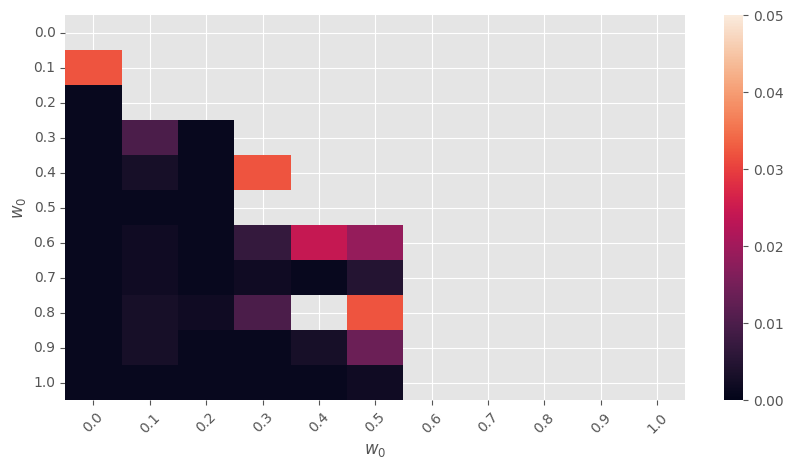

,w_0,Valor_Indicador
0,0.001,75.828923
1,0.100,76.094108
2,0.200,76.234159
3,0.300,76.454552
4,0.400,76.524328
5,0.500,76.496631
6,0.600,76.602911
7,0.700,76.650783
8,0.800,76.612061
9,0.900,76.674197


In [26]:
problema='WFG4'
n_objetivos=3
indicador='hv'


get_heatmap(df_todos_PI=df_todos_PI_IGDp,df_WC=df_WC_IGDp,problema=problema,n_objetivos=n_objetivos,indicador=indicador)


## Conteo de borda

Se define como el número de victorias que tuvo sobre los demás

In [54]:
def conteo_borda(df):
    victorias=(df<0.05).sum(axis=1).reset_index()
    return pd.DataFrame({'w_0':victorias.index, 'victorias':victorias[0]})

df_borda=df_WC_todos.reset_index().groupby(['n_objetivos','problema','indicador','hiperparam_ind_conv']).apply(conteo_borda).reset_index().drop(columns='level_4')
# df_borda=pd.read_csv('../tablas_generadas/conteo_borda_todos.csv').set_index(['n_objetivos','problema','indicador','hiperparam_ind_conv'])
df_borda=df_borda.pivot(values='victorias',index=['n_objetivos','problema','indicador','hiperparam_ind_conv'],columns='w_0')
df_borda.to_csv('../tablas_generadas/conteo_borda_todos.csv')
df_borda

w_0                                     0   1   2   3   4   5   6   7   8   \
dimension problema Indicador divers_QI                                       
2         DTLZ1    eps+      IGD+        0   0   0   0   0   0   0   0   0   
                             R2          0   0   1   3   0   0   0   0   0   
                   hv        IGD+        0   0   0   0   0   1   2   3   2   
                             R2          0   0   1   5   0   0   0   0   1   
                   igd       IGD+        0   2   0   0   0   0   0   0   0   
...                                     ..  ..  ..  ..  ..  ..  ..  ..  ..   
7         WFG9     r2        R2          0   0   0   0   0   0   0   0   0   
                   s-energy  IGD+        0   0   2   1   0   4   3   4   3   
                             R2          0   0   0   0   0   0   0   0   0   
                   spd       IGD+        1   1   0   1   1   0   1   0   1   
                             R2          0   0   0   0   0   0   0   0   0   

w_0                                     9   10  
dimension problema Indicador divers_QI          
2         DTLZ1    eps+      IGD+        0   0  
                             R2          0   0  
                   hv        IGD+        0   0  
                             R2          0   0  
                   igd       IGD+        0   3  
...                                     ..  ..  
7         WFG9     r2        R2          0   0  
                   s-energy  IGD+        5   4  
                             R2          0   0  
                   spd       IGD+        1   0  
                             R2          0   0  

[1344 rows x 11 columns]

In [27]:
df_borda=pd.read_csv('../tablas_generadas/conteo_borda_todos.csv').set_index(['n_objetivos','problema','indicador','hiperparam_ind_conv'])
df_borda=df_borda.rename_axis(columns='w_0')

In [30]:
df_borda

w_0                                     0  1  2  3  4  5  6  7  8  9  10
dimension problema Indicador divers_QI                                  
2         DTLZ1    eps+      IGD+       0  0  0  0  0  0  0  0  0  0   0
                             R2         0  0  1  3  0  0  0  0  0  0   0
                   hv        IGD+       0  0  0  0  0  1  2  3  2  0   0
                             R2         0  0  1  5  0  0  0  0  1  0   0
                   igd       IGD+       0  2  0  0  0  0  0  0  0  0   3
...                                    .. .. .. .. .. .. .. .. .. ..  ..
7         WFG9     r2        R2         0  0  0  0  0  0  0  0  0  0   0
                   s-energy  IGD+       0  0  2  1  0  4  3  4  3  5   4
                             R2         0  0  0  0  0  0  0  0  0  0   0
                   spd       IGD+       1  1  0  1  1  0  1  0  1  1   0
                             R2         0  0  0  0  0  0  0  0  0  0   0

[1344 rows x 11 columns]

In [31]:
def conteo_borda_problema(df_borda,n_objetivos,problema,indicador):
    df_vs=pd.melt(df_borda.loc[n_objetivos,problema,indicador].reset_index(),id_vars=['hiperparam_ind_conv'])
    df_vs['w_0']=df_vs['w_0'].replace({i:w_0[i][0] for i in range(len(w_0))})
    fig=px.bar(data_frame=df_vs,x='w_0',y='value',color='hiperparam_ind_conv',barmode='group')
    fig.update_layout(
        # title=f'Conteo de borda {problema} {n_objetivos}D {indicador.upper()}',
        xaxis_title='$w_0$', yaxis_title='Victorias',
        height=500, width=900
    )
    fig.write_image(f'../imgs_pdf/conteo_borda_{problema}_obj{n_objetivos}_ind{indicador}.pdf')
    fig.show()
    return df_vs

n_objetivos,problema,indicador=3,'WFG4','hv'
df_vs=conteo_borda_problema(df_borda,n_objetivos,problema,indicador)

In [33]:
df_borda_stack=df_borda.groupby(['n_objetivos','hiperparam_ind_conv'])[df_borda.columns].mean().unstack().reset_index()

for n_objetivos in df_borda_stack.n_objetivos.unique():
    df=df_borda_stack[df_borda_stack['n_objetivos']==n_objetivos].iloc[:,1:].unstack().reset_index().drop(columns=['level_2'])
    df['w_0']=df['w_0'].replace({f'{i}':w_0[i][0] for i in range(len(w_0))})
    fig=px.bar(df,x='w_0',y=0,color='hiperparam_ind_conv',barmode='group')
    fig.update_layout(
        # title=f'Conteo de borda por peso.\nNúmero de objetivos {n_objetivos}',
        xaxis_title='$w_0$', yaxis_title='Victorias Promedio',
        height=400, width=600
    )
    fig.write_image(f'../imgs_pdf/borda_obj_{n_objetivos}.pdf')
    fig.show()

In [35]:
df_borda_stack=df_borda.groupby(['indicador','hiperparam_ind_conv'])[df_borda.columns].mean().unstack().reset_index()

for indicador in df_borda_stack.indicador.unique():
    df=df_borda_stack[df_borda_stack['indicador']==indicador].iloc[:,1:].unstack().reset_index().drop(columns=['level_2'])
    df['w_0']=df['w_0'].replace({f'{i}':w_0[i][0] for i in range(len(w_0))})
 
    fig=px.bar(df,x='w_0',y=0,color='hiperparam_ind_conv',barmode='group')
    fig.update_layout(
        # title=f'Conteo de borda por peso.\nindicador {indicador}',
        xaxis_title='$w_0$', yaxis_title='Victorias Promedio',
        height=400, width=600
    )
    fig.write_image(f'../imgs_pdf/borda_obj_ind_{indicador}.pdf')

    fig.show()

El s-energy que regresa Assessment es correcto? Tendría que decrecer cuando se le da más peso. Tal vez es negativo?

In [100]:
df_WC_todos=pd.read_csv('../tablas_generadas/WC_QI_todos.csv').drop(columns=['Unnamed: 4']).set_index(['n_objetivos','problema','indicador','hiperparam_ind_conv'])

In [109]:
df_WC_todos.loc[:, :, :, "R2"]

0.001       0.1       0.2       0.3  \
dimension problema Indicador                                           
2         DTLZ1    eps+            NaN  0.862305  0.919922  0.990234   
                   eps+       0.161133       NaN  0.753906  0.784180   
                   eps+       0.096680  0.278320       NaN  0.615234   
                   eps+       0.013672  0.246094  0.422852       NaN   
                   eps+       0.384766  0.838867  0.903320  0.919922   
...                                ...       ...       ...       ...   
7         WFG9     spd        0.910144  0.841345       NaN       NaN   
                   spd        0.910144  0.841345       NaN       NaN   
                   spd        0.327360  0.327360  0.158655  0.158655   
                   spd        0.327360  0.327360  0.158655  0.158655   
                   spd        0.327360  0.142525  0.089856  0.089856   

                                   0.4       0.5  0.6000000000000001  \
dimension problema Indicador                                           
2         DTLZ1    eps+       0.652344  0.687500            0.652344   
                   eps+       0.187500  0.187500            0.500000   
                   eps+       0.116211  0.161133            0.312500   
                   eps+       0.096680  0.096680            0.312500   
                   eps+            NaN  0.615234            0.347656   
...                                ...       ...                 ...   
7         WFG9     spd             NaN       NaN                 NaN   
                   spd             NaN       NaN                 NaN   
                   spd        0.158655  0.158655            0.158655   
                   spd        0.158655  0.158655            0.158655   
                   spd        0.089856  0.089856            0.089856   

                              0.7000000000000001       0.8       0.9     0.999  
dimension problema Indicador                                                    
2         DTLZ1    eps+                 0.753906  0.721680  0.422852  0.687500  
                   eps+                 0.278320  0.312500  0.080078  0.187500  
                   eps+                 0.080078  0.080078  0.006836  0.161133  
                   eps+                 0.080078  0.096680  0.032227  0.024414  
                   eps+                 0.687500  0.500000  0.312500  0.347656  
...                                          ...       ...       ...       ...  
7         WFG9     spd                       NaN  0.841345  0.841345  0.910144  
                   spd                       NaN  0.841345  0.841345  0.910144  
                   spd                  0.158655       NaN       NaN  0.672640  
                   spd                  0.158655       NaN       NaN  0.672640  
                   spd                  0.089856  0.327360  0.327360       NaN  

[7392 rows x 11 columns]